---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------
## Caveats
### Demonstrating known caveats and tweaks in `spaghetti`

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook demonstrates the following limitations and caveats:**

1. Limitations in non-planarity
2. Relaxing vertex coordinate precision
3. Distance matrices between (dis)connected components

# `vertex_atol` -- maybe just `atol`
# plot connectivity weights...
# compare to fuzzy weights...
# tests
# docs...


In [2]:
%load_ext watermark
%watermark

2020-03-22T22:13:56-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [3]:
import geopandas
import libpysal
from libpysal.cg import Point, Chain
import matplotlib
import matplotlib.pyplot as plt
import numpy
import spaghetti
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
libpysal   4.2.2
geopandas  0.7.0
matplotlib 3.1.2
numpy      1.17.3
spaghetti  1.4.2.post2



In [4]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

##### Helper functions for arc and vertex labeling

In [16]:
def arc_labels(a, b, s):
    """Label each network arc."""
    def _lab_loc(_x):
        """Helper for labeling network arcs."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]
    kws = {"size": s, "ha": "center", "va": "bottom"}
    a.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

def vert_labels(v, b, s):
    """Label each network vertex."""
    def _lab_loc(_x):
        """Internal helper for labeling vertices."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "weight": "bold"}
    v.apply(lambda x: b.annotate(s=x.comp_label, xy=_lab_loc(x), **kws), axis=1)       

-----------------------
### 1. Limitations in non-planarity
#### a) Barbed wire example
##### Create some line segments of ``libpysal.cg.Chain`` objects

In [6]:
lines = [
    Chain([Point((2,7)), Point((2,3))]),
    Chain([Point((2,3)), Point((0,3))]),
    Chain([Point((0,3)), Point((0,5))]),
    Chain([Point((0,5)), Point((5,5))]),
    Chain([Point((5,5)), Point((5,7))]),
    Chain([Point((5,7)), Point((3,7))]),
    Chain([Point((3,7)), Point((3,3))])
]
lines

##### Instantiate a ``spaghetti.Network`` object

In [7]:
ntw = spaghetti.Network(in_data=lines, extractgraph=False)

##### Extract the network vertices and arcs

In [8]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices_df

,id,geometry,comp_label
0,0,POINT (2.00000 7.00000),0
1,1,POINT (2.00000 3.00000),0
2,2,POINT (0.00000 3.00000),0
3,3,POINT (0.00000 5.00000),0
4,4,POINT (5.00000 5.00000),0
5,5,POINT (5.00000 7.00000),0
6,6,POINT (3.00000 7.00000),0
7,7,POINT (3.00000 3.00000),0


In [9]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 7.00000, 2.00000 3.00000)",0
1,"(1, 2)","LINESTRING (2.00000 3.00000, 0.00000 3.00000)",0
2,"(2, 3)","LINESTRING (0.00000 3.00000, 0.00000 5.00000)",0
3,"(3, 4)","LINESTRING (0.00000 5.00000, 5.00000 5.00000)",0
4,"(4, 5)","LINESTRING (5.00000 5.00000, 5.00000 7.00000)",0
5,"(5, 6)","LINESTRING (5.00000 7.00000, 3.00000 7.00000)",0
6,"(6, 7)","LINESTRING (3.00000 7.00000, 3.00000 3.00000)",0


##### Plot

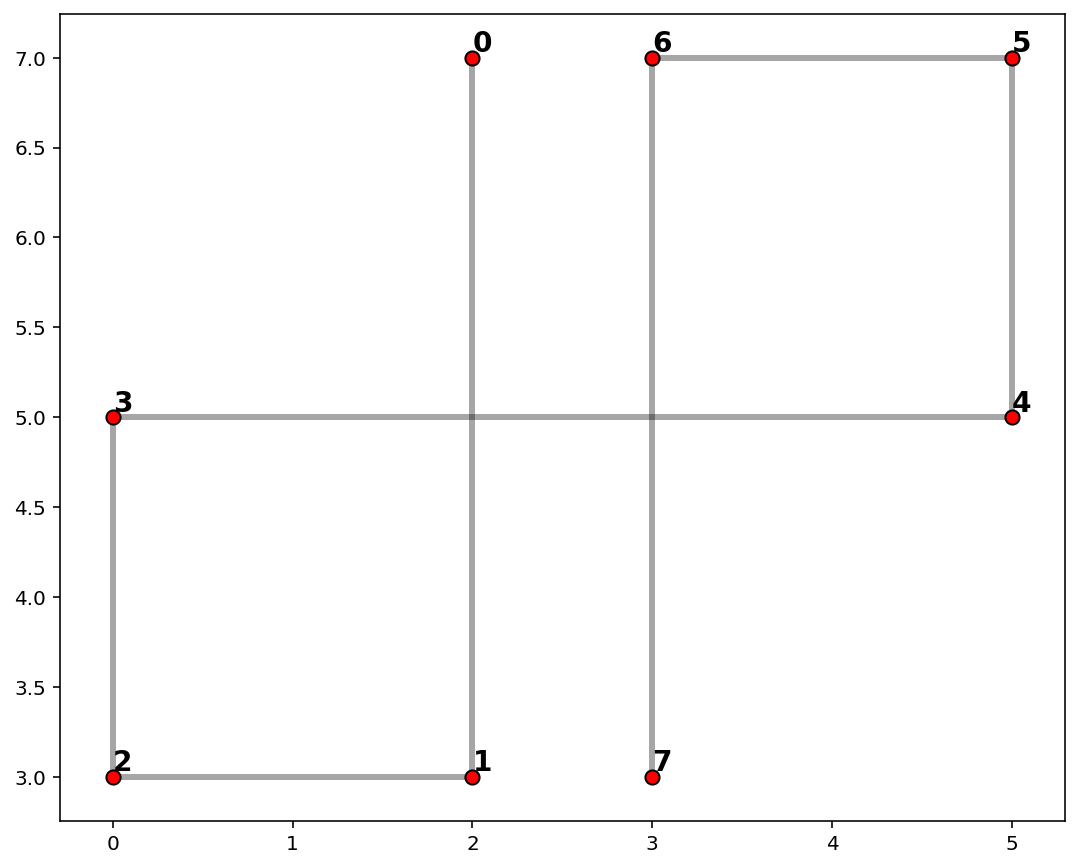

In [15]:
base = arcs_df.plot(lw=3, color="k", alpha=.35, figsize=(9, 9))
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)
# vertex labels
vert_labels(vertices_df, base, 14)

**The plot above shows network arcs in gray and vertices in red. Since there are no actual intersections between segments ``(0,1),(3,4)`` or ``(3,4),(6,7)``, there are no vertices. Therefore a shortest path from vertex ``0`` to ``7`` must follow the route ``{1,2,3,4,5,6}`` for a total of 21 units of distance.**

In [28]:
ntw.full_distance_matrix(n_processes=1, gen_tree=True)

In [29]:
ntw.network_trees[0][7]

[6, 5, 4, 3, 2, 1, 0]

In [31]:
ntw.distance_matrix[0][7]

21.0

#### b) Goalpost example
##### Create some line segments of ``libpysal.cg.Chain`` objects

In [52]:
U = [Chain([Point((2,2)), Point((2,1)), Point((4,1)), Point((4,2))])]
I = [Chain([Point((3,0)), Point((3,1))])]
arcs = U + I
arcs

##### Instantiate a ``spaghetti.Network`` object

In [53]:
ntw = spaghetti.Network(in_data=arcs)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (4, 5).
  warnings.warn(message)
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There are 2 islands with ids: (0, 3), (4, 5).
  warnings.warn(message)


##### Examine the componets
**There are two components:**

In [54]:
ntw.network_n_components

2

**Component ``0`` includes 4 vertices (the "goal") and component ``1`` includes 2 (the "post"):**

In [55]:
ntw.network_component_vertices

{0: [0, 1, 2, 3], 1: [4, 5]}

##### Extract the network vertices and arcs

In [56]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vertices_df

,id,geometry,comp_label
0,0,POINT (2.00000 2.00000),0
1,1,POINT (2.00000 1.00000),0
2,2,POINT (4.00000 1.00000),0
3,3,POINT (4.00000 2.00000),0
4,4,POINT (3.00000 0.00000),1
5,5,POINT (3.00000 1.00000),1


In [57]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 2.00000, 2.00000 1.00000)",0
1,"(1, 2)","LINESTRING (2.00000 1.00000, 4.00000 1.00000)",0
2,"(2, 3)","LINESTRING (4.00000 1.00000, 4.00000 2.00000)",0
3,"(4, 5)","LINESTRING (3.00000 0.00000, 3.00000 1.00000)",1


##### Plot

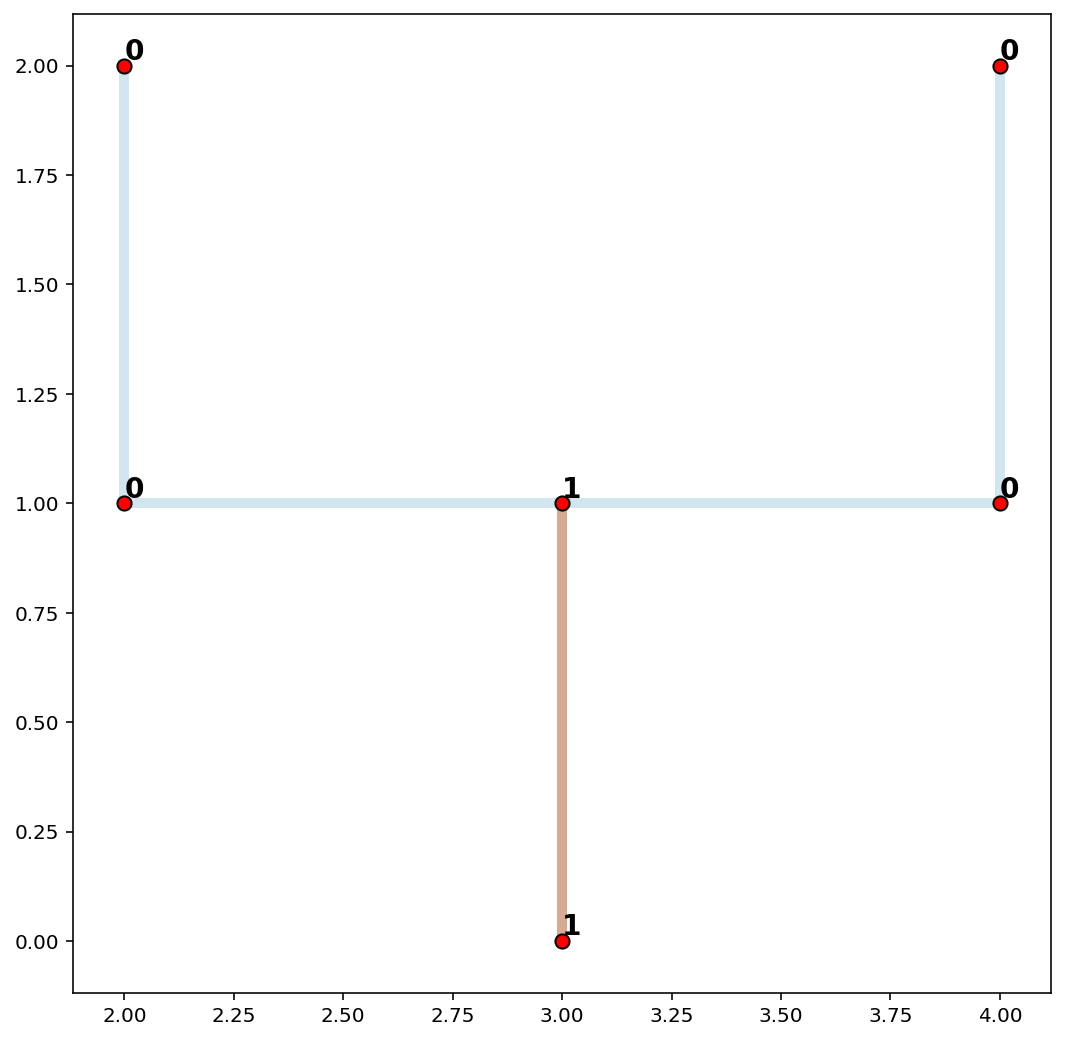

In [67]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), **base_kws)
#vertices_df.plot(ax=base, color="k", markersize=40, zorder=2)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)


# vertex labels
vert_labels(vertices_df, base, 14)

**As stated previously, flow from one network segment to another is only possible when segments share a vertex. In this case, no vertex is actually shared, although superficially there does appear to be. The plot above visualizes this concept by showing the two (dis)connected components of the "goalpost" network. Network arcs are colored by component membership and vertices are labeled by component membership. This is also demonstrated below when overlaying a plot of ``libpysal.weights.W``.**

In [59]:
arcs_df

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (2.00000 2.00000, 2.00000 1.00000)",0
1,"(1, 2)","LINESTRING (2.00000 1.00000, 4.00000 1.00000)",0
2,"(2, 3)","LINESTRING (4.00000 1.00000, 4.00000 2.00000)",0
3,"(4, 5)","LINESTRING (3.00000 0.00000, 3.00000 1.00000)",1


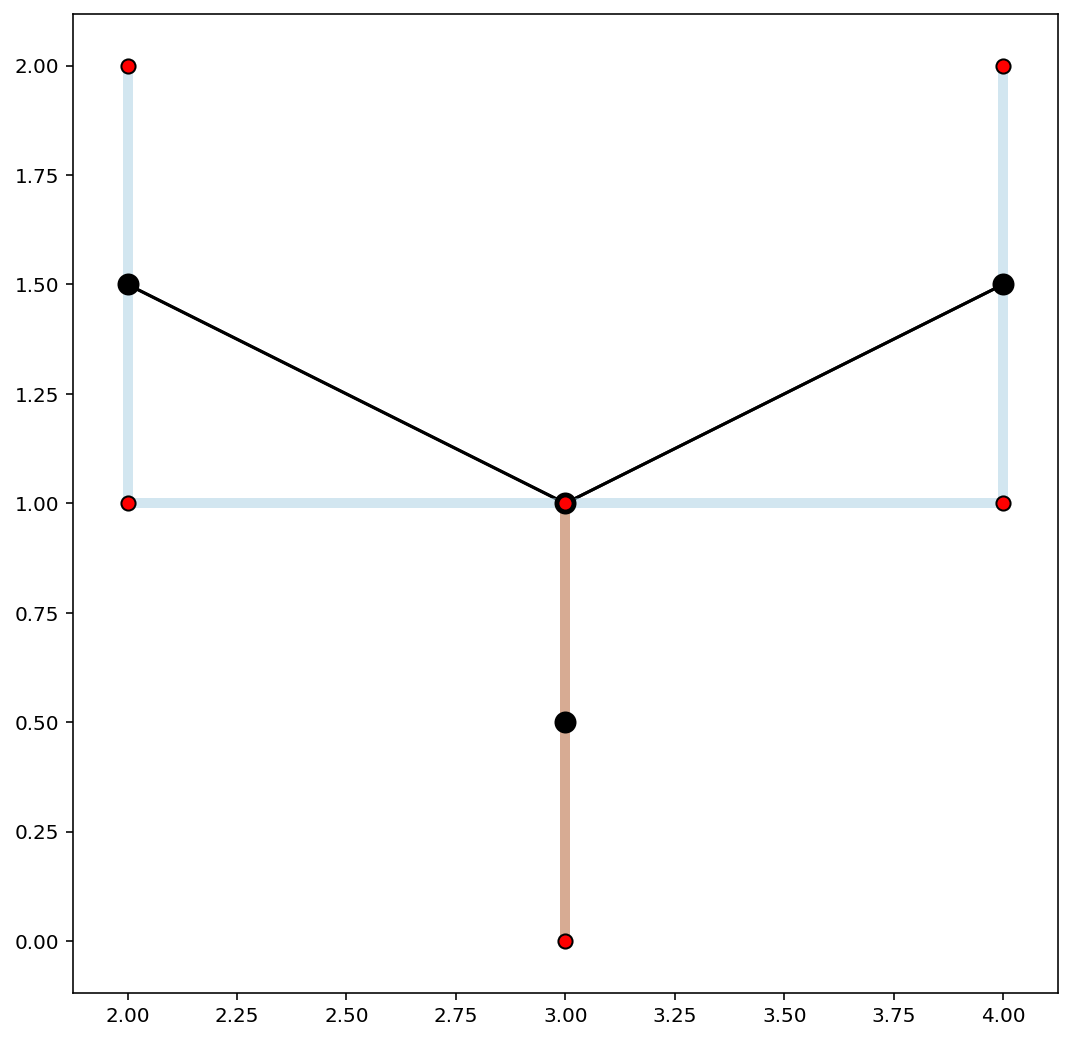

In [69]:
base_kws = {"alpha":.5, "lw":5, "cmap":"Paired", "column":"comp_label"}
base = arcs_df.plot(figsize=(9, 9), **base_kws)

node_kws = {"s":100, "zorder":2}
edge_kws = {"zorder":1}
w_kws = {"edge_kws":edge_kws, "node_kws":node_kws}
ntw.w_network.plot(arcs_df, indexed_on="id", ax=base, **w_kws)
vertices_df.plot(ax=base, fc="r", ec="k", markersize=50, zorder=2)

#vertices_df.plot(ax=base, color="k", markersize=40, zorder=2)
# vertex labels
#vert_labels(vertices_df, base, 14)

**However, if the line segments were digitized properly.....**

In [ ]:
# L (backwards)L
#     I

#### c) Empirical Example — John Snow's Cholera Map

In [44]:
soho = geopandas.read_file(libpysal.examples.get_path("Soho_Network.shp"))
soho = soho.to_crs(epsg=32630)
soho

,Id,geometry
0,0,"LINESTRING (698394.862 5710772.742, 698230.823..."
1,0,"LINESTRING (698373.590 5710607.200, 698481.244..."
2,0,"LINESTRING (698466.845 5710652.970, 698381.993..."
3,0,"LINESTRING (698373.590 5710607.200, 698322.058..."
4,0,"LINESTRING (698322.058 5710573.561, 698304.893..."
...,...,...
113,0,"LINESTRING (698851.874 5710691.953, 698837.518..."
114,0,"LINESTRING (698860.680 5710803.234, 698825.980..."
115,0,"LINESTRING (698748.567 5710903.073, 698703.656..."
116,0,"LINESTRING (698715.115 5710881.223, 698695.567..."


In [45]:
ntw = spaghetti.Network(in_data=soho, vertex_atol=None)
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
 There are 24 islands with ids: (22, 23), (28, 29), (30, 31), (47, 48), (49, 50), (58, 59), (67, 68), (75, 76), (84, 85), (86, 87), (108, 109), (110, 111), (121, 122), (128, 129), (172, 173), (183, 184), (185, 186), (190, 191), (208, 209), (212, 213), (216, 217), (218, 219), (220, 221), (222, 223).
  warnings.warn(message)
/Users/jgaboardi/miniconda3/envs/py3_spgh_dev/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
 There are 37 islands with ids: (5, 149), (22, 23), (24, 27), (28, 29), (30, 31), (47, 48), (49, 50), (58, 59), (67, 68), (72, 74), (75, 76), (84, 85), (86, 87), (89, 90), (108, 109), (110, 111), (121, 122), (124, 127), (128, 129), (150, 152), (153, 155), (163, 215), (

NameError: name 'elem_kws' is not defined

-----------------------
### 2. Precision limitations and/or known issues with digitization
#### Slightly imprecise coordinates

#### Revisting with the "goalpost" network

#### Empirical Example

-----------------------
### 3. Distance matrices for multiple connected components
#### Continuing with the "goalpost" network

-----------------------